In solar wind, we want to know roughly where our plasma is coming from on the Sun. 

Plasma from the same solar surface origin can be seen either with one spacecraft making an orbit / corotation of the Sun or with multiple spacecraft 

In [1]:
import numpy as np
import scipy as sp
import astropy
import astropy.units as u
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sunpy
from sunpy.coordinates import spice
import sys
import pandas as pd

mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams['font.family'] = 'sans-serif'

#I like to hold some relevant constants in memory, just in case i need them at PSP

oneAU = 149597871 * 10 **3 #m
oneSolR = 6.957 *10 ** 8 #m
e = 1.607 * 10 ** -19 #Coulomb
m = 1.672 * 10 ** -27 #kg 
mu0 = 4 * np.pi * 10 ** -7 #N/A^2

let's look at Encounter 11, which has multiple spacecraft lined up at the same time!

In [16]:
start11 = datetime(2022,2,20)
end11 = datetime(2022,3, 3) 
#NB usually the Encounter only refers to the 10 days at perihelion, but for now we've extended the timespan 


#e.g. just under a month of time, taken at timesteps of 1 hour using datetimes. 
times = np.arange(start11, end11, timedelta(hours = 1))


In [17]:
from sunpy.data import cache


SolObase_url = f'http://spiftp.esac.esa.int/data/SPICE/SOLAR-ORBITER/kernels/'
KERNELS_TO_LOAD   = [
                           'fk/solo_ANC_soc-sc-fk_V09.tf',
                           'fk/solo_ANC_soc-ops-fk_V02.tf',
                           'fk/solo_ANC_soc-sci-fk_V08.tf',
                           'fk/earth_topo_050714.tf',
                           'fk/estrack_v04.tf',

                           'ik/solo_ANC_soc-epd-ik_V03.ti',
                           'ik/solo_ANC_soc-eui-ik_V01.ti',
                           'ik/solo_ANC_soc-metis-ik_V03.ti',
                           'ik/solo_ANC_soc-phi-ik_V01.ti',
                           'ik/solo_ANC_soc-solohi-ik_V01.ti',
                           'ik/solo_ANC_soc-spice-ik_V02.ti',
                           'ik/solo_ANC_soc-stix-ik_V02.ti',
                           'ik/solo_ANC_soc-swa-ik_V03.ti',

                           'lsk/naif0012.tls',

                           'pck/pck00010.tpc',

                           'pck/earth_070425_370426_predict.bpc',

                           'sclk/solo_ANC_soc-sclk-fict_20000101_V01.tsc',

                           'spk/solo_ANC_soc-orbit_20200210-20301120_L019_V1_00387_V01.bsp',
                           'spk/solo_ANC_soc-orbit-stp_20200210-20301120_338_V1_00401_V01.bsp',
                           'spk/de421.bsp',
                           'spk/earthstns_itrf93_050714.bsp',
                           'spk/estrack_v04.bsp',
                           'spk/earthnpole_19500101_20251231_v01.bsp'
]

solokernelurl = [f'http://spiftp.esac.esa.int/data/SPICE/SOLAR-ORBITER/kernels/{url}' for url in KERNELS_TO_LOAD]
solokernelurl.append(f'https://spdf.gsfc.nasa.gov/pub/data/psp/ephemeris/spice/ephemerides/spp_nom_20180812_20250831_v038_RO5.bsp') # this finds the parker solar probe prediction SPICE kernel from the start to late 2025
# there are ways to download and initialize all the parker solar probe kernels at once, which involve creating your own metakernel of measurements and formulae (and therefore kernels) you'd need to download

SolOkernel_files = [cache.download(url) for url in solokernelurl]

spice.initialize(SolOkernel_files)

INFO: Removing 131 existing SPICE frame classes [sunpy.coordinates.spice]
INFO: Removing 50 existing SPICE origin classes [sunpy.coordinates.spice]
INFO: Installing SOLO_IAU_SUN_2003 PCK frame (-144994) as 'spice_SOLO_IAU_SUN_2003' [sunpy.coordinates.spice]
INFO: Creating ICRF frame with SUN (10) origin [sunpy.coordinates.spice]
INFO: Installing SOLO_IAU_SUN_2009 PCK frame (-144993) as 'spice_SOLO_IAU_SUN_2009' [sunpy.coordinates.spice]
INFO: Installing SOLO_STIX_ILS CK frame (-144851) as 'spice_SOLO_STIX_ILS' [sunpy.coordinates.spice]
INFO: Creating ICRF frame with SOLAR-ORBITER (-144) origin [sunpy.coordinates.spice]
INFO: Installing SOLO_SPICE_LW_ILS CK frame (-144821) as 'spice_SOLO_SPICE_LW_ILS' [sunpy.coordinates.spice]
INFO: Installing SOLO_SPICE_SW_ILS CK frame (-144811) as 'spice_SOLO_SPICE_SW_ILS' [sunpy.coordinates.spice]
INFO: Installing SOLO_SOLOHI_ILS CK frame (-144701) as 'spice_SOLO_SOLOHI_ILS' [sunpy.coordinates.spice]
INFO: Installing SOLO_PHI_HRT_ILS CK frame (-14452

having downloaded the spice kernels, we use them to reconstruct our orbits

In [18]:
# the frame transformation to the Heliographic Carrington frame of reference (this is the longitude of the spacecraft relative to the Sun's rotation)
HeliographicCarrington = sunpy.coordinates.HeliographicCarrington(observer='self') 
HeliographicStonyhurst = sunpy.coordinates.HeliographicStonyhurst()

SPICESolOrbit = spice.get_body('Solar Orbiter', times, ) # create the orbit data from the SPICE kernels at the times defined
SPICEPSPorbit = spice.get_body('Parker Solar Probe', times, )

SPICESolOrbit =SPICESolOrbit.transform_to(HeliographicCarrington) # we put them in the heliographic carrington coordinate system - decide for yourself if this is what you want
SPICEPSPorbit =SPICEPSPorbit.transform_to(HeliographicCarrington)

SPICESolOrbitdf = pd.DataFrame({'radius':SPICESolOrbit.radius.to(astropy.units.AU), 'lon':SPICESolOrbit.lon, 'lat':SPICESolOrbit.lat}, index = SPICESolOrbit.obstime) # make dataframes 
SPICEPSPorbitdf = pd.DataFrame({'radius':SPICEPSPorbit.radius.to(astropy.units.AU), 'lon':SPICEPSPorbit.lon, 'lat':SPICEPSPorbit.lat}, index = SPICEPSPorbit.obstime)

Ballistic mapping hinges on the idea that the plasma is travelling in a roughly straight line, assuming no external forces, but the solar surface is rotating

The magnetic field becomes radial at roughly the PFSS (potential free source surface), so this is a less controversial point to map back to

In [22]:
sun_rot = (14.713 )/(24*3600) #degrees per second
pfss = 2.5 #radial source surface as 2.5 solar radii: this is generally a good place to map back to; it's not the same as the solar footpoint necessarily

In [24]:
pfss * oneSolR / oneAU

0.011626168129090553

so the solar wind plasma coming out with a nominal velocity traces the parker spiral in the Sun's rotating frame
$$\Delta R = v \Delta t$$
$$\Delta \phi = \omega_{\odot}\Delta t $$
$\Delta R$ is the change in distance, $v$ is the speed, $\Delta t$ is the time taken in travel, $\phi$ is the Carrington longitude, $\omega_{\odot}$ is the solar rotation rate
so $$\phi_{1} = \phi_{0} + \Delta \phi = \phi_{0} - \omega_{\odot} \frac{\Delta R}{v}$$

If you can make the plot below, then you basically have everything you need for ballistic mapping

Text(0.5, 1.0, 'Orbits Relative to the Surface of the Sun')

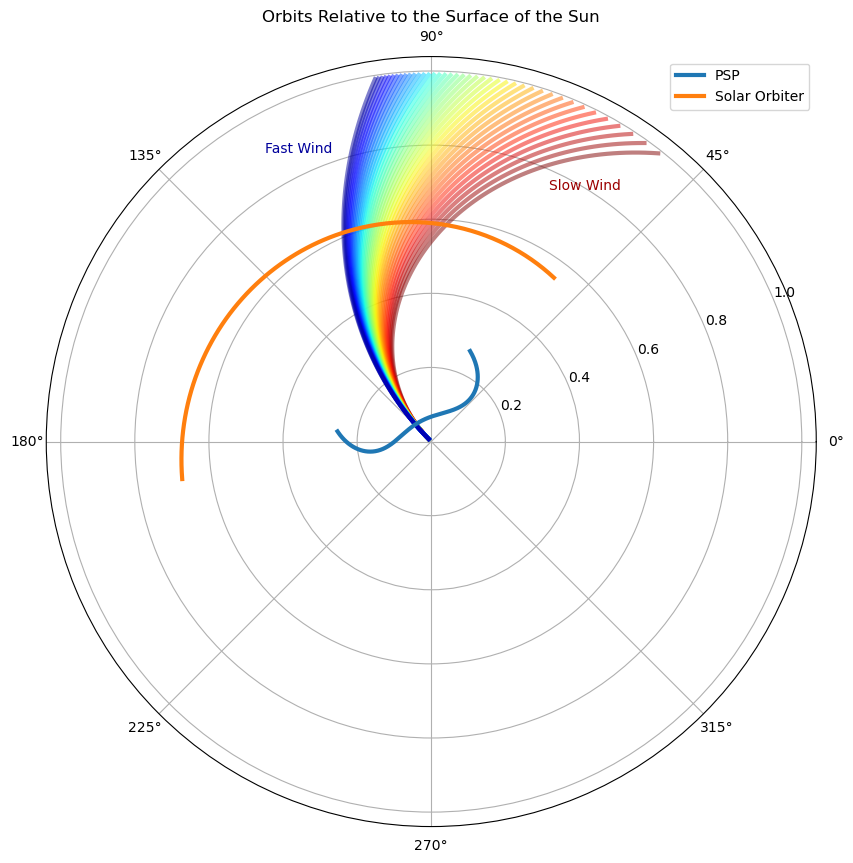

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},  figsize = (10,10))

#let's make some nice gradiented plots of different speed winds
xs = np.arange(0.01,1,0.01) #radius in AU, roughly starting from the pfss

vs = np.arange(300,700,10) #speeds in km/s
lon0 = 135 #let's aim at 135 degrees to hit the 2 spacecraft
cmap = mpl.colormaps['jet']
for v, c in list(zip(vs,cmap((vs -700)/-400))):
    phis = lon0 - ((xs - 0.01)*oneAU / 1000 / v * sun_rot)
    ax.plot(phis*np.pi/180, xs, linewidth = 3, color = c, alpha = 0.5)
    if v == 310:
        ax.text(65*np.pi/180, 0.75, 'Slow Wind', color = c)
    elif v == 690:
        ax.text(120*np.pi/180, 0.9, 'Fast Wind', color = c)



ax.plot(SPICEPSPorbitdf.lon * np.pi / 180 , SPICEPSPorbitdf.radius, linewidth = 3, label = 'PSP')
ax.plot(SPICESolOrbitdf.lon * np.pi / 180 , SPICESolOrbitdf.radius, linewidth = 3, label = 'Solar Orbiter')

ax.legend()
plt.title('Orbits Relative to the Rotating Surface of the Sun' )

# Getting the data

So we need to know our speeds! For now we're assuming that the plasma is shooting around in the ecliptic plane. This is not always the case and in general, taking the latitude into account means a factor of $\text{sin}(\theta)$ somewhere in the work.

In [58]:
from sunpy.net import Fido, attrs as a
import sunpy_soar
MAGinstrument = a.Instrument('MAG')
SWAinstrument = a.Instrument('SWA')
time = a.Time(start11,end11) # a period of time between the start and end periods specified
level = a.Level(2) # the level of data that you want to search for.


Once you have the data that you want, download it via Fido.fetch

In [61]:
# for example we may want the magnetic field data in the normal mode, depicted in the RTN coordinate system
MAGproduct = a.soar.Product('mag-rtn-normal')
result = Fido.search(MAGproduct & time)
files = Fido.fetch(result) # now we download the files

Files Downloaded:   0%|          | 0/12 [00:00<?, ?file/s]

Sunpy tries to make life easy by provided the "timeseries" method - which turns your data into a timeseries, and this can then be turned into a pandas dataframe!

In [62]:
import sunpy.timeseries
# Load the time varying data from cdfs
MAGtimeseries = sunpy.timeseries.TimeSeries(files, concatenate = True,) # concatenate means that all the files downloaded will go into one timeseries object


In [63]:
# sunpy timeseries aren't the easiest thing to look at so let's look at them as Pandas dataframes!
import pandas as pd
MAGdf = MAGtimeseries.to_dataframe()

timeseries.to_dataframe() is a method that converts the timeseries to a dataframe. as a result, the dataframe index is a list of datetime objects

In [ ]:
renamedict = {'B_RTN_0':'BR','B_RTN_1':'BT','B_RTN_2':'BN'}
MAGdf.rename(columns = renamedict, inplace = True)
print(MAGdf)

                                     BR        BT        BN  QUALITY_BITMASK  \
EPOCH                                                                          
2022-02-20 00:00:00.118999555  2.631647 -4.970902  5.032236              128   
2022-02-20 00:00:00.244003906  2.828553 -4.847302  5.061373              128   
2022-02-20 00:00:00.368998199  3.044172 -4.777864  5.061108              128   
2022-02-20 00:00:00.494002550  3.225910 -4.678187  5.082552              128   
2022-02-20 00:00:00.618996843  3.367857 -4.653024  5.115238              128   
...                                 ...       ...       ...              ...   
2022-03-03 23:59:59.455997720 -9.739042  6.512091 -8.357775              160   
2022-03-03 23:59:59.581002071 -9.759981  6.757251 -8.155151              160   
2022-03-03 23:59:59.705996364 -9.766231  6.850400 -7.870780              160   
2022-03-03 23:59:59.831000715 -9.709337  7.269117 -7.336288              160   
2022-03-03 23:59:59.955995008 -9.851912 

Notice how the magnetic field data is occuring every 0.125 seconds, or at a rate of 8 Hz
If you want to work with both magnetic field data and plasma particle data, you'll want to interpolate between the mag field and particles

In [65]:
#let's download the particle data as well

PASproducts = a.soar.Product('swa-pas-grnd-mom') #getting the moments
result = Fido.search(time & PASproducts)
files = Fido.fetch(result)
PAStimeseries = sunpy.timeseries.TimeSeries(files, concatenate = True)
PASdf = PAStimeseries.to_dataframe()


Files Downloaded:   0%|          | 0/12 [00:00<?, ?file/s]

2025-10-31 18:43:32 - sunpy - WARNING: SunpyUserWarning: astropy did not recognize units of "Ticks". Assigning dimensionless units. If you think this unit should not be dimensionless, please raise an issue at https://github.com/sunpy/sunpy/issues
2025-10-31 18:43:33 - sunpy - WARNING: SunpyUserWarning: astropy did not recognize units of "Ticks". Assigning dimensionless units. If you think this unit should not be dimensionless, please raise an issue at https://github.com/sunpy/sunpy/issues
2025-10-31 18:43:33 - sunpy - WARNING: SunpyUserWarning: astropy did not recognize units of "Ticks". Assigning dimensionless units. If you think this unit should not be dimensionless, please raise an issue at https://github.com/sunpy/sunpy/issues
2025-10-31 18:43:33 - sunpy - WARNING: SunpyUserWarning: astropy did not recognize units of "Ticks". Assigning dimensionless units. If you think this unit should not be dimensionless, please raise an issue at https://github.com/sunpy/sunpy/issues
2025-10-31 1

In [66]:
# for ease, we only want the RTN coordinate system 
# sometimes you'll want the data in the spacecraft reference frame - which is SRF
renameDict = {'V_RTN_0':'VR', 'V_RTN_1':'VT', 'V_RTN_2':'VN'}
keeplist = ['VR','VT','VN']
PASdf.rename(columns = renameDict, inplace = True)

droplist = [] #let's throw away a lot of the data that we don't always need to use
for column in PASdf.columns: 
    if column not in keeplist:
        droplist.append(column)
PASdf.drop(columns = droplist, inplace = True)
print(PASdf.index)

DatetimeIndex(['2022-02-20 00:00:00.045208', '2022-02-20 00:00:04.045215',
               '2022-02-20 00:00:08.045222', '2022-02-20 00:00:12.045229',
               '2022-02-20 00:00:16.045236', '2022-02-20 00:00:20.045243',
               '2022-02-20 00:00:24.045250', '2022-02-20 00:00:28.045256',
               '2022-02-20 00:00:32.045263', '2022-02-20 00:00:36.045270',
               ...
               '2022-03-03 23:59:17.841672', '2022-03-03 23:59:21.841679',
               '2022-03-03 23:59:25.841686', '2022-03-03 23:59:29.841693',
               '2022-03-03 23:59:33.841700', '2022-03-03 23:59:37.841707',
               '2022-03-03 23:59:41.841714', '2022-03-03 23:59:45.841720',
               '2022-03-03 23:59:49.841727', '2022-03-03 23:59:53.841734'],
              dtype='datetime64[ns]', name='Epoch', length=245173, freq=None)


In [67]:
import numpy as np
#there are a few intricacies to interpolation, but just for now let's interpolate the data directly.
#depending on your analyses you may want to interpolate between a smoothed magnetic field or to not interpolate at all if you are dealing with fourier series 
PASdf['BR'] = np.interp( PASdf.index, MAGdf.index, MAGdf['BR'])
PASdf['BT'] = np.interp( PASdf.index, MAGdf.index, MAGdf['BT'])
PASdf['BN'] = np.interp( PASdf.index, MAGdf.index, MAGdf['BN'])

and then the PSP data as well